# 클러스터링 분석

## K-means, GMM, Spectral, HDBSCAN 클러스터링 적용

## XAI 해석 (SHAP, LIME, Permutation Importance 적용)

### 사용할 라이브러리

In [9]:
import pandas as pd
import numpy as np
import os
import tqdm as tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

import shap
import lime
import lime.lime_tabular
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

import FinanceDataReader as fdr
from bs4 import BeautifulSoup
import requests
import re
import random

from scipy.stats import ttest_1samp
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.optimize import minimize

In [10]:
# macOS에서 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스(-)가 깨질 수 있는 것을 방지함
plt.rcParams['axes.unicode_minus'] = False


### 데이터 불러오기

In [11]:
df = pd.read_csv("csv_files/financial_data_processing_cospi200.csv")
# df = df[df['기업명_그룹'] != '삼성전자']
df

,기업명_그룹,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,BGF리테일,78168.10,2353.90,1806.20,30413.75,10074.50,173.00,6499.40,3371.05,3.0045,2.3025,19.1640,6.1845,204.4665,10452.15,13.842000,58318.90,2.5360,17283906.0
1,BNK금융지주,82983.75,9329.10,7427.55,1402323.10,106667.95,16297.00,1059.20,194600.65,12.1160,9.5230,7.2460,0.5505,1212.4140,2177.75,3.688000,31087.35,0.2545,323323988.3
2,CJ,399896.75,21261.65,4553.45,459940.30,173529.85,1790.00,43187.50,182317.25,5.2905,1.1735,3.2850,1.0215,164.8735,4743.30,23.256000,157376.10,0.5830,29176998.0
3,CJ대한통운,117828.20,4457.35,2185.80,95146.65,40917.65,1141.00,6244.35,33233.10,3.7705,1.8440,5.1870,2.3095,132.5530,8222.50,18.852000,183922.25,0.6120,22812344.0
4,CJ제일제당,284474.55,14863.60,6214.55,290387.75,115612.75,819.00,20663.90,110318.45,5.2365,2.2195,6.7945,2.2100,151.2490,25676.20,16.468500,433280.45,0.7875,15054186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,현대해상,168437.95,10420.80,7558.30,476717.70,60701.60,447.00,14037.90,16655.60,6.3260,4.5935,12.1730,1.5880,746.7925,8454.75,3.715000,77333.60,0.3630,89400000.0
195,호텔신라,39464.80,361.90,-312.55,31713.35,7943.10,2000.00,1265.10,16232.85,0.8090,-0.8505,-3.0005,-0.9120,336.9375,-781.90,3.286643,20980.10,3.7785,39248121.0
196,효성중공업,40082.75,2242.65,1152.10,49684.20,13957.55,466.00,2791.35,12929.00,5.2690,2.6040,8.2110,2.2965,269.5100,11180.00,21.237749,135929.25,1.2290,9324548.0
197,효성티앤씨,77966.55,3994.95,2516.70,42602.50,15773.25,216.00,5586.25,13711.75,5.0295,3.1635,18.9360,6.5965,177.7275,45108.25,33.786000,295216.55,1.1600,4327682.0


In [12]:
# 기업명을 따로 저장한 후, feature만 따로 분리함
company = df['기업명_그룹']
X_raw = df.drop(columns=["기업명_그룹"])

X_raw

,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,78168.10,2353.90,1806.20,30413.75,10074.50,173.00,6499.40,3371.05,3.0045,2.3025,19.1640,6.1845,204.4665,10452.15,13.842000,58318.90,2.5360,17283906.0
1,82983.75,9329.10,7427.55,1402323.10,106667.95,16297.00,1059.20,194600.65,12.1160,9.5230,7.2460,0.5505,1212.4140,2177.75,3.688000,31087.35,0.2545,323323988.3
2,399896.75,21261.65,4553.45,459940.30,173529.85,1790.00,43187.50,182317.25,5.2905,1.1735,3.2850,1.0215,164.8735,4743.30,23.256000,157376.10,0.5830,29176998.0
3,117828.20,4457.35,2185.80,95146.65,40917.65,1141.00,6244.35,33233.10,3.7705,1.8440,5.1870,2.3095,132.5530,8222.50,18.852000,183922.25,0.6120,22812344.0
4,284474.55,14863.60,6214.55,290387.75,115612.75,819.00,20663.90,110318.45,5.2365,2.2195,6.7945,2.2100,151.2490,25676.20,16.468500,433280.45,0.7875,15054186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,168437.95,10420.80,7558.30,476717.70,60701.60,447.00,14037.90,16655.60,6.3260,4.5935,12.1730,1.5880,746.7925,8454.75,3.715000,77333.60,0.3630,89400000.0
195,39464.80,361.90,-312.55,31713.35,7943.10,2000.00,1265.10,16232.85,0.8090,-0.8505,-3.0005,-0.9120,336.9375,-781.90,3.286643,20980.10,3.7785,39248121.0
196,40082.75,2242.65,1152.10,49684.20,13957.55,466.00,2791.35,12929.00,5.2690,2.6040,8.2110,2.2965,269.5100,11180.00,21.237749,135929.25,1.2290,9324548.0
197,77966.55,3994.95,2516.70,42602.50,15773.25,216.00,5586.25,13711.75,5.0295,3.1635,18.9360,6.5965,177.7275,45108.25,33.786000,295216.55,1.1600,4327682.0


### 다중공선성 제거 (VIF > 10)

In [13]:
# X_raw에 상수항 추가 (VIF 계산을 위한 절차)
X_with_const = sm.add_constant(X_raw)

# VIF 계산
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(X_with_const.shape[1])]

low_vif_features = vif_data[vif_data['VIF'] <= 10]['Feature']
low_vif_features = low_vif_features[low_vif_features != 'const']  # const 제외

vif_data


,Feature,VIF
0,const,5.172654
1,매출액,15.227366
2,영업이익,80.739303
3,당기순이익,115.238007
4,자산총계,6.957816
5,자본총계,70.153867
6,자본금,2.694876
7,영업활동현금흐름,20.333518
8,이자발생부채,8.888133
9,영업이익률,2.488562


In [14]:
low_vif_features

4       자산총계
6        자본금
8     이자발생부채
9      영업이익률
10      순이익률
11    ROE(%)
12    ROA(%)
13      부채비율
14    EPS(원)
15    PER(배)
16    BPS(원)
17    PBR(배)
Name: Feature, dtype: object

In [15]:
X_raw = X_raw[low_vif_features]

### Feature scaling 수행

In [16]:
# StandardScaler로 정규화한다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
# X_scaled 데이터를 DataFrame으로 변환
X_scaled_df = pd.DataFrame(X_scaled, columns=X_raw.columns)

### 클러스터링 적용 및 평가 함수 정의

In [17]:
# 클러스터링 성능 평가 함수를 정의함 
# Silhouette Score를 사용함
def evaluate_clustering(model, X, labels=None):
    if (labels is None):
        labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

### 최적의 K 찾기

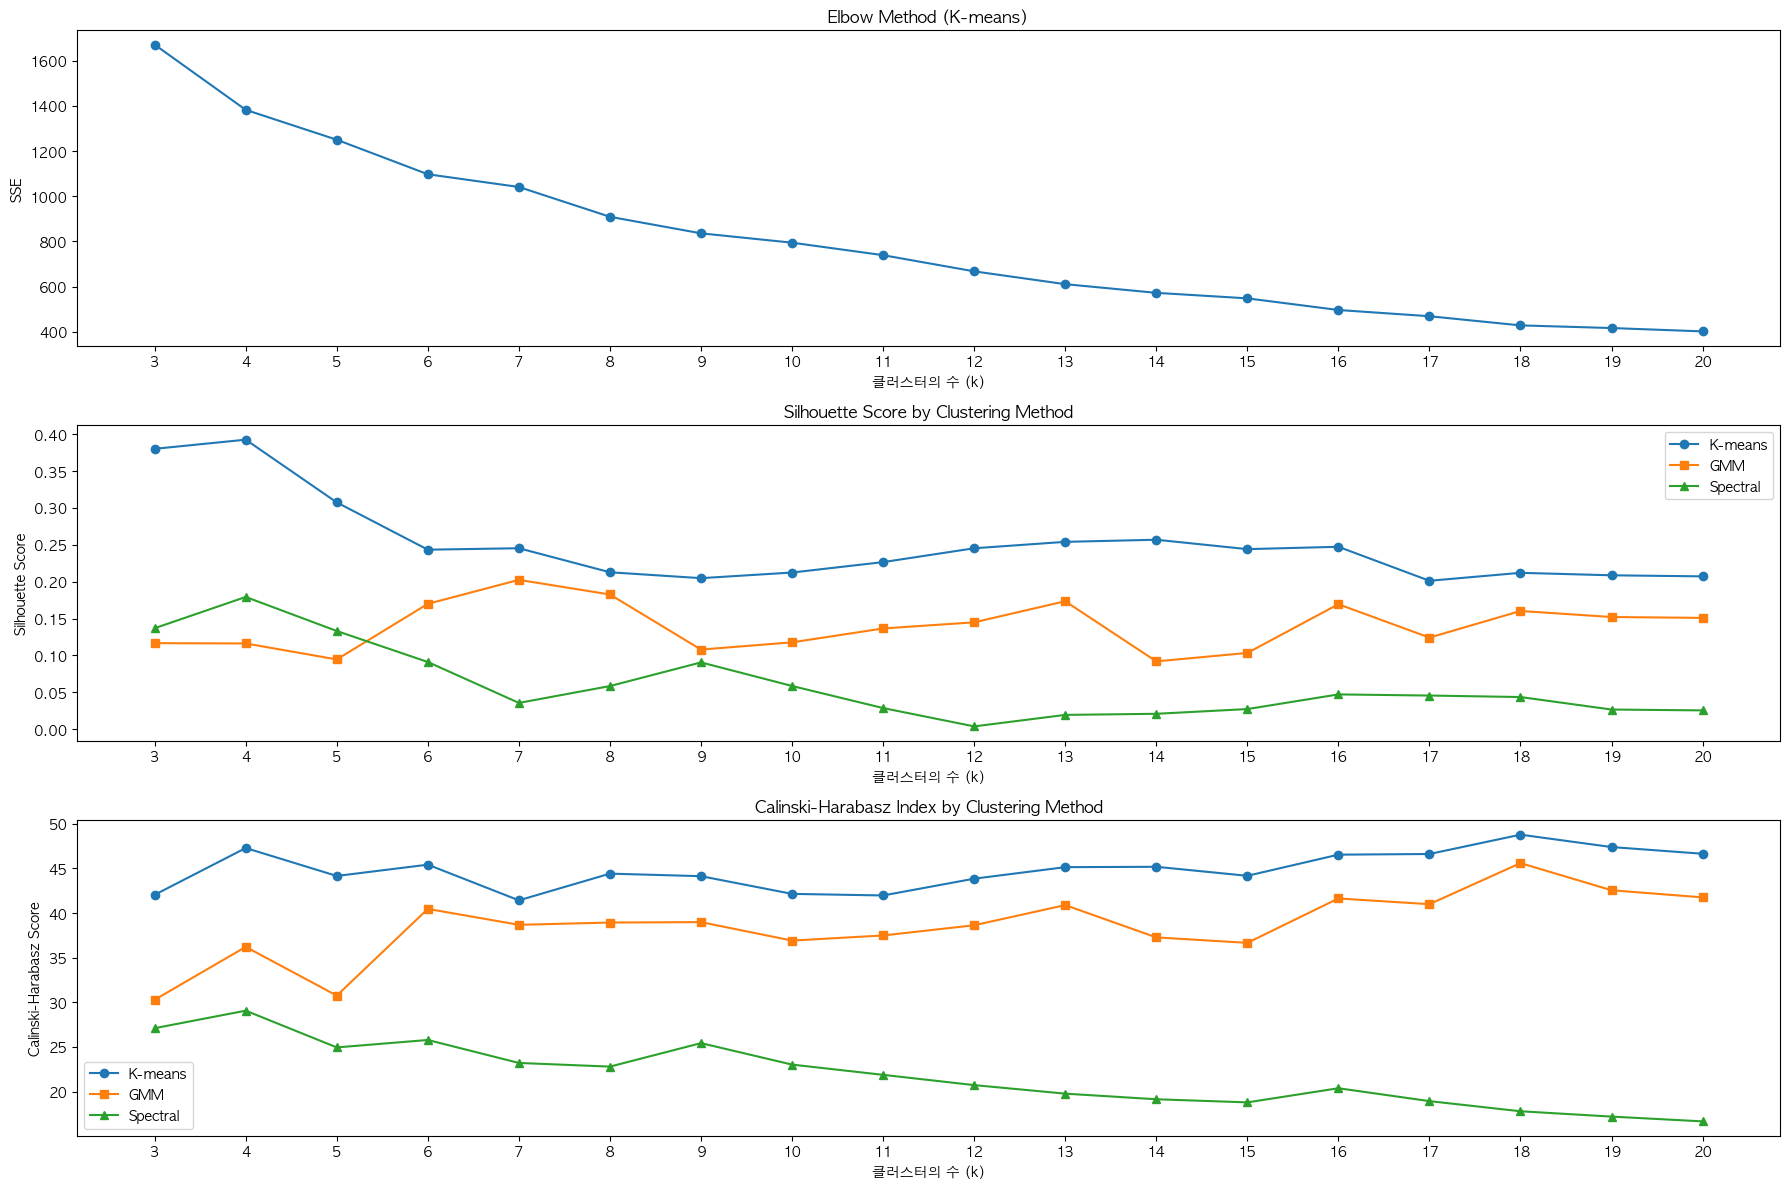

In [29]:
# 후보 K 값 범위 설정
k_values = range(3, 21)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, kmeans_labels))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    gmm_silhouette_scores.append(silhouette_score(X_scaled, gmm_labels))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled, gmm_labels))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels = spectral.fit_predict(X_scaled)
    spectral_silhouette_scores.append(silhouette_score(X_scaled, spectral_labels))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled, spectral_labels))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### K-means, GMM, Spectral Clustering 적용 및 비교

Best K for KMeans (lowest DBI): 15 -> DBI = 0.8195
Best K for GMM (lowest DBI): 16 -> DBI = 0.8935
Best K for Spectral Clustering (lowest DBI): 9 -> DBI = 1.2576


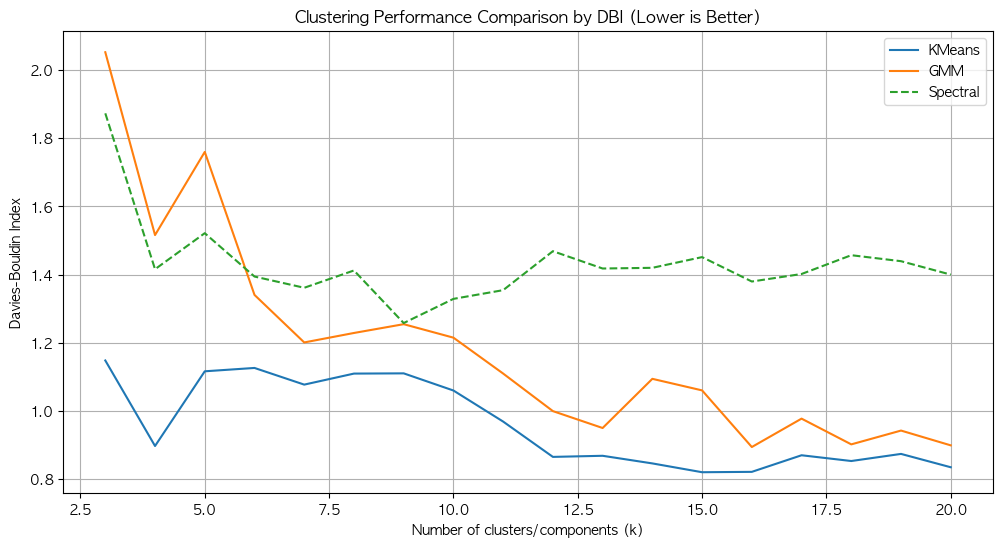

In [31]:
# 결과 저장
k_range = range(3, 21)

dbi_kmeans, dbi_gmm, dbi_spectral = [], [], []

labels_kmeans_all, labels_gmm_all, labels_spectral_all = {}, {}, {}

# 반복 수행
for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(X_scaled)
    dbi_kmeans.append(davies_bouldin_score(X_scaled, kmeans_labels))
    labels_kmeans_all[k] = kmeans_labels

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    dbi_gmm.append(davies_bouldin_score(X_scaled, gmm_labels))
    labels_gmm_all[k] = gmm_labels

    # Spectral Clustering
    try:
        spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
        spectral_labels = spectral.fit_predict(X_scaled)
        dbi_spectral.append(davies_bouldin_score(X_scaled, spectral_labels))
        labels_spectral_all[k] = spectral_labels

    except Exception:
        # 실패한 경우 큰 값으로 대체 (e.g., affinity 문제 등)
        dbi_spectral.append(np.inf)
        labels_spectral_all[k] = None


# 가장 낮은 DBI를 보이는 k 찾기
best_k_kmeans = k_range[np.argmin(dbi_kmeans)]
best_k_gmm = k_range[np.argmin(dbi_gmm)]
best_k_spectral = k_range[np.argmin(dbi_spectral)]

# 결과 출력
print(f"Best K for KMeans (lowest DBI): {best_k_kmeans} -> DBI = {min(dbi_kmeans):.4f}")
print(f"Best K for GMM (lowest DBI): {best_k_gmm} -> DBI = {min(dbi_gmm):.4f}")
print(f"Best K for Spectral Clustering (lowest DBI): {best_k_spectral} -> DBI = {min(dbi_spectral):.4f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_range, dbi_kmeans, label='KMeans')
plt.plot(k_range, dbi_gmm, label='GMM')
plt.plot(k_range, dbi_spectral, label='Spectral', linestyle='--')
plt.xlabel('Number of clusters/components (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Clustering Performance Comparison by DBI (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [32]:
best_dbi_kmeans = min(dbi_kmeans)
best_dbi_gmm = min(dbi_gmm)
best_dbi_spectral = min(dbi_spectral)

# 세 모델 중 가장 낮은 DBI 찾기
min_dbi = min(best_dbi_kmeans, best_dbi_gmm, best_dbi_spectral)

if min_dbi == best_dbi_kmeans:
    print(f"KMeans selected: k={best_k_kmeans}, DBI={best_dbi_kmeans:.4f}")
    df['Cluster'] = labels_kmeans_all[best_k_kmeans]
elif min_dbi == best_dbi_gmm:
    print(f"GMM selected: k={best_k_gmm}, DBI={best_dbi_gmm:.4f}")
    df['Cluster'] = labels_gmm_all[best_k_gmm]
else:
    print(f"Spectral Clustering selected: k={best_k_spectral}, DBI={best_dbi_spectral:.4f}")
    df['Cluster'] = labels_spectral_all[best_k_spectral]

KMeans selected: k=15, DBI=0.8195


### Random Forest 학습 - XAI 해석용

In [33]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled, df['Cluster'])

RandomForestClassifier(random_state=42)

### SHAP 해석

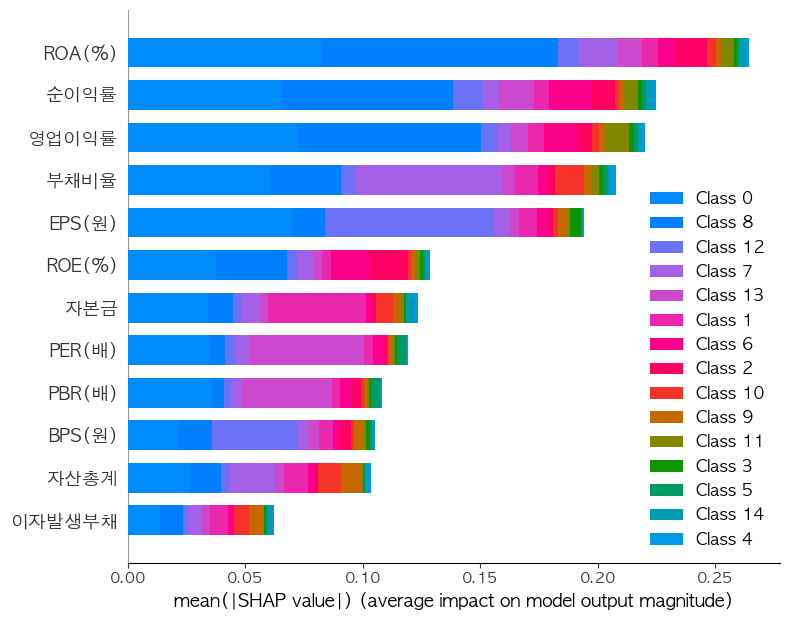

In [34]:
# SHAP 분석
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_scaled)

# feature importance를 시각화함
shap.summary_plot(shap_values, X_raw, plot_type="bar")

In [36]:
feature_names = X_raw.columns
num_classes = len(shap_values)
top_n = 5

for class_idx in range(num_classes):
    print(f"\n🟩 Class {class_idx}에서 가장 중요한 Feature TOP {top_n}:\n" + "-"*50)

    # 클래스별 SHAP 절댓값 평균 계산
    class_shap = np.abs(shap_values[class_idx]).mean(axis=0)
    
    # 실제 feature 개수와 맞추기
    num_features = min(len(feature_names), len(class_shap))
    top_idx = np.argsort(class_shap[:num_features])[::-1][:top_n]

    for i in top_idx:
        print(f"{feature_names[i]}: 평균 SHAP = {class_shap[i]:.4f}")



🟩 Class 0에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP = 0.0445
EPS(원): 평균 SHAP = 0.0302
부채비율: 평균 SHAP = 0.0075
자본금: 평균 SHAP = 0.0046
PBR(배): 평균 SHAP = 0.0042

🟩 Class 1에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
부채비율: 평균 SHAP = 0.0599
자산총계: 평균 SHAP = 0.0438
EPS(원): 평균 SHAP = 0.0420
자본금: 평균 SHAP = 0.0111
BPS(원): 평균 SHAP = 0.0101

🟩 Class 2에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP = 0.0494
EPS(원): 평균 SHAP = 0.0189
부채비율: 평균 SHAP = 0.0116
자본금: 평균 SHAP = 0.0075
ROA(%): 평균 SHAP = 0.0039

🟩 Class 3에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP = 0.0474
EPS(원): 평균 SHAP = 0.0199
부채비율: 평균 SHAP = 0.0077
자본금: 평균 SHAP = 0.0047
ROA(%): 평균 SHAP = 0.0037

🟩 Class 4에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP = 0.0643
EPS(원): 평균 SHAP = 0.0194
부채비율: 평균 SHAP = 0.0071
PER(배): 평균 SHAP = 0.0058
자본

### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### 각 cluster에 어떤 종목이 포함되어 있는지 확인

In [49]:
# 클러스터 수 결정 (선택된 모델 기준)
if min_dbi == best_dbi_kmeans:
    selected_labels = labels_kmeans_all[best_k_kmeans]
    num_clusters = best_k_kmeans
    model_name = "KMeans"
elif min_dbi == best_dbi_gmm:
    selected_labels = labels_gmm_all[best_k_gmm]
    num_clusters = best_k_gmm
    model_name = "GMM"
else:
    selected_labels = labels_spectral_all[best_k_spectral]
    num_clusters = best_k_spectral
    model_name = "Spectral Clustering"

print(f"\n📊 클러스터링 결과 ({model_name} 선택됨, 클러스터 수 = {num_clusters})")

# 클러스터별 종목 리스트 출력
cluster_dict = {}

for cluster_id in range(num_clusters):
    stock_list = company[selected_labels == cluster_id].values.tolist()
    cluster_dict[cluster_id] = stock_list  # ✅ 저장
    
    print(f"\n[클러스터 {cluster_id}에 속한 종목들] ({len(stock_list)}개):")
    print(", ".join(stock_list))




📊 클러스터링 결과 (KMeans 선택됨, 클러스터 수 = 15)

[클러스터 0에 속한 종목들] (83개):
BGF리테일, CJ, CJ대한통운, DL, DL이앤씨, GS, GS건설, GS리테일, HD한국조선해양, HD현대, HD현대미포, HD현대인프라코어, HL만도, KG모빌리티, KT, LG전자, LG화학, LIG넥스원, LS, LS ELECTRIC, LX인터내셔널, OCI, S-Oil, SK네트웍스, SK아이이테크놀로지, SK이노베이션, SK케미칼, SK텔레콤, TCC스틸, 강원랜드, 금호타이어, 넷마블, 녹십자, 녹십자홀딩스, 대상, 대웅제약, 대한유화, 대한전선, 동원시스템즈, 롯데쇼핑, 롯데웰푸드, 롯데지주, 롯데칠성, 롯데케미칼, 미스토홀딩스, 삼성물산, 삼성에스디에스, 삼아알미늄, 세방전지, 세아베스틸지주, 아모레퍼시픽, 아모레퍼시픽홀딩스, 유한양행, 율촌화학, 이마트, 카카오, 코스맥스, 코스모화학, 코오롱인더, 팬오션, 포스코인터내셔널, 풍산, 하이트진로, 한국가스공사, 한국콜마, 한국항공우주, 한미사이언스, 한샘, 한세실업, 한온시스템, 한전기술, 한화비전, 한화솔루션, 한화시스템, 현대건설, 현대로템, 현대백화점, 현대엘리베이터, 현대위아, 현대제철, 호텔신라, 효성중공업, 후성

[클러스터 1에 속한 종목들] (9개):
LG유플러스, SK하이닉스, 기아, 대우건설, 대한항공, 두산에너빌리티, 미래에셋증권, 카카오뱅크, 한화생명

[클러스터 2에 속한 종목들] (5개):
F&F, SK바이오팜, 에스디바이오센서, 에이피알, 한미반도체

[클러스터 3에 속한 종목들] (1개):
태광산업

[클러스터 4에 속한 종목들] (1개):
기업은행

[클러스터 5에 속한 종목들] (1개):
에코프로머티

[클러스터 6에 속한 종목들] (8개):
GKL, LG디스플레이, SKC, 두산, 삼성중공업, 엘앤에프, 하나투어, 한화오션

[클러스터 7에 속한 종목들] (12개):
BNK금융지주, DB손해보험, JB금융지주, NH투자증권, iM금융지주, 메리츠금

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

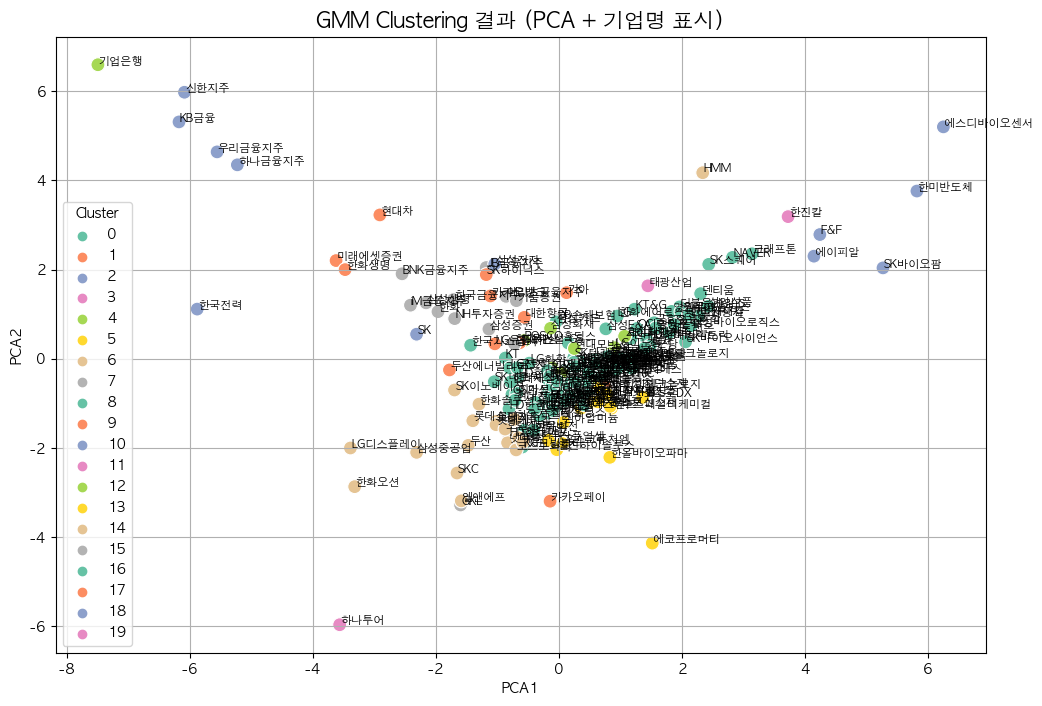

In [38]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company.values,
    'Cluster': kmeans_labels,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

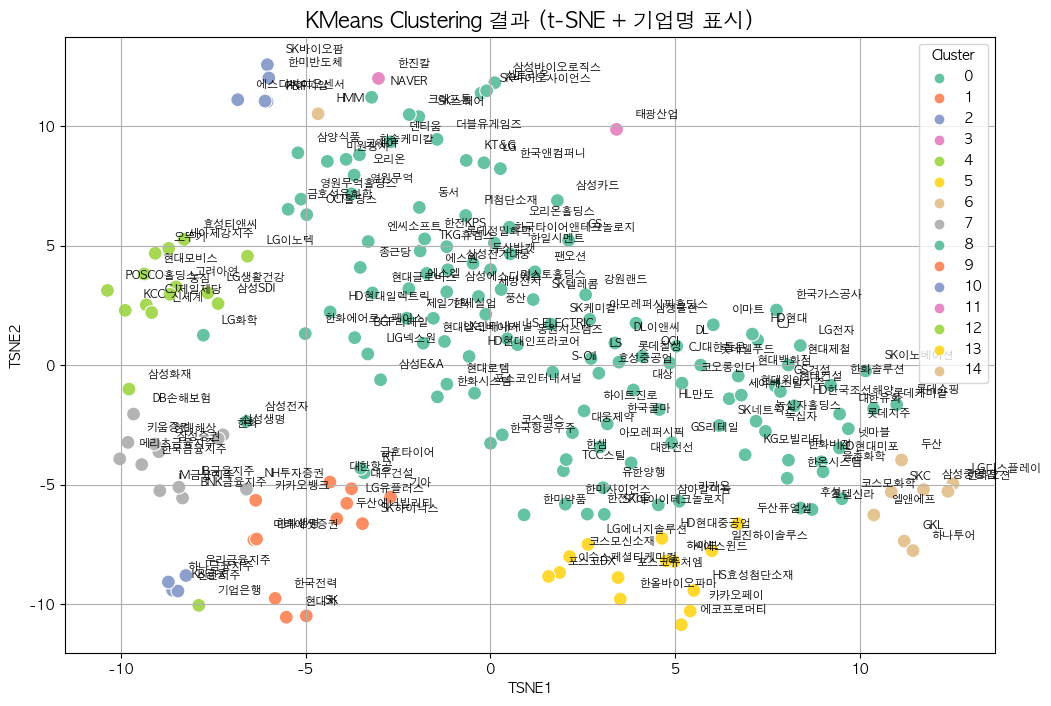

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

df_clustered = pd.DataFrame({
    '기업명': company.values,
    'Cluster': selected_labels,
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1]
})

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['TSNE1'][i]+0.5, df_clustered['TSNE2'][i]+0.5, df_clustered['기업명'][i], fontsize=8)
plt.title(f"{model_name} Clustering 결과 (t-SNE + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# 포트폴리오

## 랜덤 Selected Portfolio와 클러스터 기반 Portfolio 성과 비교

### 로그 수익률 데이터로 변환

In [43]:
BaseUrl = 'http://finance.naver.com/sise/entryJongmok.nhn?&page='

stock_codes = []

for i in range(1, 21):  # range() 함수의 끝 파라미터는 포함되지 않는다.
    url = BaseUrl + str(i)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    items = soup.find_all('td', {'class': 'ctg'})
    for item in items:
        txt = item.a.get('href')  # 예: https://finance.naver.com/item/main.nhn?code=006390
        k = re.search('[\d]+', txt)  # 정규표현식 사용. [\d] 숫자표현, + : 반복
        if k:
            code = k.group()
            stock_codes.append(code)

asset_df = pd.read_csv('csv_files/kospi200_no_nan.csv')
asset_df['Date'] = pd.to_datetime(asset_df['Date'], format='%Y-%m-%d')
asset_df.set_index('Date', inplace=True)

returns_df = np.log(asset_df / asset_df.shift(1)).dropna()
# returns_df = asset_df.pct_change().dropna()
returns_df


,005930,000660,207940,005380,012450,068270,000270,105560,035420,055550,...,069260,001430,003620,005420,006650,002710,178920,093370,105630,006110
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.005420,-0.002114,-0.015286,-0.017094,0.004309,-0.013987,-0.011834,0.012807,-0.005495,0.003515,...,-0.007308,-0.006689,-0.012134,-0.020399,-0.017392,0.005700,0.011429,0.009776,-0.005780,-0.010471
2020-01-06,0.000000,-0.002119,-0.023982,0.000000,0.008590,-0.025684,-0.002384,-0.011733,-0.005525,-0.015321,...,-0.022251,-0.023770,-0.024613,0.045372,-0.044851,-0.011050,-0.034686,-0.029747,-0.017544,-0.002342
2020-01-07,0.005391,-0.003186,0.016847,-0.004320,-0.014348,0.028494,0.003574,0.008547,0.035378,0.015321,...,0.002497,-0.006897,0.000000,-0.015557,-0.013857,0.011050,0.023257,0.013781,0.020439,0.001172
2020-01-08,0.017762,0.035531,-0.025379,-0.030772,-0.016002,-0.028494,-0.017997,-0.018251,-0.021622,-0.017700,...,-0.038124,-0.046026,-0.059009,-0.060737,-0.042762,-0.047332,-0.053110,-0.049487,-0.053425,-0.016529
2020-01-09,0.031198,0.016294,0.027764,-0.004474,0.005851,0.022859,-0.013407,0.007555,0.016261,0.004751,...,-0.002594,0.003617,0.023479,0.080720,0.038100,0.034365,0.032790,0.085946,0.030032,0.007117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.009390,0.006507,0.010593,0.021152,0.066586,0.007246,-0.002969,0.013889,-0.043803,0.021528,...,0.015193,0.022751,0.019318,0.038173,0.008833,0.029593,0.040040,0.021761,0.040880,0.024304
2024-12-24,0.016682,-0.006507,-0.011659,0.006953,-0.006154,0.002572,-0.002978,-0.005764,0.007435,0.002026,...,-0.001617,-0.007362,-0.011546,-0.018904,-0.006301,-0.019048,-0.001138,-0.021761,-0.009018,-0.011364
2024-12-26,-0.014815,0.009451,-0.001067,0.004608,-0.001544,-0.015026,0.022605,-0.011628,-0.012923,-0.010173,...,-0.005408,-0.002466,-0.015605,-0.014094,-0.014004,-0.033781,-0.015495,-0.011061,-0.003490,-0.023122


In [44]:
target_tickers = stock_codes

# 전체 한국 상장 종목 불러오기
krx = fdr.StockListing('KRX')

# 티커-종목명 매핑
ticker_filtered_name_dict = {}

for ticker in target_tickers:
    name = krx.loc[krx['Code'] == ticker, 'Name']
    if not name.empty:
        ticker_filtered_name_dict[ticker] = name.values[0]
    else:
        ticker_filtered_name_dict[ticker] = None  # 못 찾은 경우 None 처리

# 결과 확인
print(ticker_filtered_name_dict)

{'005930': '삼성전자', '000660': 'SK하이닉스', '373220': 'LG에너지솔루션', '207940': '삼성바이오로직스', '005380': '현대차', '012450': '한화에어로스페이스', '068270': '셀트리온', '000270': '기아', '329180': 'HD현대중공업', '105560': 'KB금융', '035420': 'NAVER', '055550': '신한지주', '012330': '현대모비스', '042660': '한화오션', '138040': '메리츠금융지주', '005490': 'POSCO홀딩스', '028260': '삼성물산', '009540': 'HD한국조선해양', '034020': '두산에너빌리티', '086790': '하나금융지주', '259960': '크래프톤', '000810': '삼성화재', '032830': '삼성생명', '035720': '카카오', '010130': '고려아연', '015760': '한국전력', '011200': 'HMM', '051910': 'LG화학', '096770': 'SK이노베이션', '033780': 'KT&G', '316140': '우리금융지주', '030200': 'KT', '010140': '삼성중공업', '064350': '현대로템', '024110': '기업은행', '006400': '삼성SDI', '402340': 'SK스퀘어', '066570': 'LG전자', '017670': 'SK텔레콤', '352820': '하이브', '267260': 'HD현대일렉트릭', '323410': '카카오뱅크', '003550': 'LG', '018260': '삼성에스디에스', '003670': '포스코퓨처엠', '034730': 'SK', '000100': '유한양행', '009150': '삼성전기', '047050': '포스코인터내셔널', '086280': '현대글로비스', '326030': 'SK바이오팜', '047810': '한국항공우주', '003490': 

In [45]:
columns_renamed = {}

for col in returns_df.columns:
    if col == 'Date':
        columns_renamed[col] = 'Date'
    else:
        columns_renamed[col] = ticker_filtered_name_dict.get(col, col)  # 매칭 안 되면 기존 col 이름 유지

# 컬럼명 변경
returns_df.rename(columns=columns_renamed, inplace=True)

# 결과 확인
returns_df.head()


,삼성전자,SK하이닉스,삼성바이오로직스,현대차,한화에어로스페이스,셀트리온,기아,KB금융,NAVER,신한지주,...,TKG휴켐스,세아베스틸지주,KG모빌리티,코스모화학,대한유화,TCC스틸,PI첨단소재,후성,한세실업,삼아알미늄
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.005420,-0.002114,-0.015286,-0.017094,0.004309,-0.013987,-0.011834,0.012807,-0.005495,0.003515,...,-0.007308,-0.006689,-0.012134,-0.020399,-0.017392,0.005700,0.011429,0.009776,-0.005780,-0.010471
2020-01-06,0.000000,-0.002119,-0.023982,0.000000,0.008590,-0.025684,-0.002384,-0.011733,-0.005525,-0.015321,...,-0.022251,-0.023770,-0.024613,0.045372,-0.044851,-0.011050,-0.034686,-0.029747,-0.017544,-0.002342
2020-01-07,0.005391,-0.003186,0.016847,-0.004320,-0.014348,0.028494,0.003574,0.008547,0.035378,0.015321,...,0.002497,-0.006897,0.000000,-0.015557,-0.013857,0.011050,0.023257,0.013781,0.020439,0.001172
2020-01-08,0.017762,0.035531,-0.025379,-0.030772,-0.016002,-0.028494,-0.017997,-0.018251,-0.021622,-0.017700,...,-0.038124,-0.046026,-0.059009,-0.060737,-0.042762,-0.047332,-0.053110,-0.049487,-0.053425,-0.016529
2020-01-09,0.031198,0.016294,0.027764,-0.004474,0.005851,0.022859,-0.013407,0.007555,0.016261,0.004751,...,-0.002594,0.003617,0.023479,0.080720,0.038100,0.034365,0.032790,0.085946,0.030032,0.007117


### 수익률에 NaN값이 있는 종목은 클러스터에서 제외

In [50]:
# returns_df에 실제 존재하는 종목 리스트
available_stocks = set(returns_df.columns)

# cluster_dict에서 returns_df 기준으로 종목 필터링
filtered_clusters = {}

for cluster_id, stock_list in cluster_dict.items():
    filtered = [stock for stock in stock_list if stock in available_stocks]
    print(f"cluster_{cluster_id}: {len(stock_list)} → {len(filtered)} (available)")
    filtered_clusters[cluster_id] = filtered

# 이후에는 filtered_clusters[i] 사용

cluster_0: 83 → 79 (available)
cluster_1: 9 → 8 (available)
cluster_2: 5 → 1 (available)
cluster_3: 1 → 1 (available)
cluster_4: 1 → 1 (available)
cluster_5: 1 → 0 (available)
cluster_6: 8 → 8 (available)
cluster_7: 12 → 12 (available)
cluster_8: 43 → 40 (available)
cluster_9: 3 → 3 (available)
cluster_10: 4 → 4 (available)
cluster_11: 1 → 1 (available)
cluster_12: 14 → 14 (available)
cluster_13: 13 → 7 (available)
cluster_14: 1 → 1 (available)


### In/Out Sample 기간 설정

In [51]:
# 데이터 기간 확인
start_date = returns_df.index.min()
end_date = returns_df.index.max()

# 총 기간이 5년임을 고려하여 4년(in-sample), 1년(out-sample)으로 나누기
cutoff_date = start_date + pd.DateOffset(years=4)
returns_in_sample = returns_df.loc[start_date:cutoff_date - pd.DateOffset(days=1)]
returns_out_sample = returns_df.loc[cutoff_date:end_date]

# 결과 미리 보기
returns_in_sample.shape, returns_out_sample.shape, cutoff_date


((987, 180), (243, 180), Timestamp('2024-01-03 00:00:00'))

### Markowitz Portfolio Optimization 모형

In [52]:
def markowitz_min_variance(returns: pd.DataFrame, target_return: float = 0.01):
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values
    num_assets = len(mean_returns)

    # 포트폴리오 분산 (리스크) 계산
    def portfolio_variance(weights):
        return weights.T @ cov_matrix @ weights

    # 제약조건: 총합 = 1, 기대 수익률 ≥ target_return
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: w @ mean_returns - target_return}
    ]

    # 비중 범위 (0~1)
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = np.repeat(1 / num_assets, num_assets)

    result = minimize(portfolio_variance, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("최적화 실패: ", result.message)


### 각 클러스터에 대응하는 random portfolio 생성

In [54]:
# 재현 가능성 확보
random.seed(42)

all_stocks = list(returns_df.columns)

cluster_results = {}
random_results_by_cluster = {}

for cluster_id, cluster in filtered_clusters.items():
    cluster_name = f'filtered_cluster_{cluster_id}'
    cluster_size = len(cluster)
    
    if cluster_size < 5:
        print(f"{cluster_name}: 종목 수가 {cluster_size}개로 적어 생략")
        continue

    print(f"{cluster_name}: 최적화 및 랜덤 비교 시작 (종목 수 {cluster_size})")

    # (1) 클러스터 포트폴리오 수익률 계산
    try:
        cluster_ret_in = returns_in_sample[cluster].dropna()
        cluster_ret_out = returns_out_sample[cluster].dropna()
        
        weights = markowitz_min_variance(cluster_ret_in, target_return=cluster_ret_in.mean().mean())
        cluster_in_pf = cluster_ret_in @ weights
        cluster_out_pf = cluster_ret_out @ weights

        cluster_results[cluster_name] = {
            'weights': weights,
            'in_sample': cluster_in_pf,
            'out_sample': cluster_out_pf
        }

    except Exception as e:
        print(f"{cluster_name}: 최적화 실패 - {e}")
        continue

    # (2) 랜덤 포트폴리오 100개 생성 및 비교
    random_portfolios = []
    for _ in range(100):
        random_stocks = random.sample(all_stocks, cluster_size)
        random_portfolios.append(random_stocks)

    random_returns_in = []
    random_returns_out = []

    for stock_list in random_portfolios:
        subset_in = returns_in_sample[stock_list].dropna()
        subset_out = returns_out_sample[stock_list].dropna()
        
        # 너무 많은 결측치나 종목 손실 시 skip
        if subset_in.shape[1] < cluster_size * 0.8 or subset_out.shape[1] < cluster_size * 0.8:
            continue

        try:
            rand_weights = markowitz_min_variance(subset_in, target_return=subset_in.mean().mean())
            rand_in_pf = subset_in @ rand_weights
            rand_out_pf = subset_out @ rand_weights

            random_returns_in.append(rand_in_pf)
            random_returns_out.append(rand_out_pf)
        except:
            continue

    random_results_by_cluster[cluster_name] = {
        'in_sample': random_returns_in,
        'out_sample': random_returns_out
    }

    print(f"{cluster_name}: 랜덤 포트폴리오 {len(random_returns_in)}개 완료")


filtered_cluster_0: 최적화 및 랜덤 비교 시작 (종목 수 79)
filtered_cluster_0: 랜덤 포트폴리오 100개 완료
filtered_cluster_1: 최적화 및 랜덤 비교 시작 (종목 수 8)
filtered_cluster_1: 랜덤 포트폴리오 100개 완료
filtered_cluster_2: 종목 수가 1개로 적어 생략
filtered_cluster_3: 종목 수가 1개로 적어 생략
filtered_cluster_4: 종목 수가 1개로 적어 생략
filtered_cluster_5: 종목 수가 0개로 적어 생략
filtered_cluster_6: 최적화 및 랜덤 비교 시작 (종목 수 8)
filtered_cluster_6: 랜덤 포트폴리오 100개 완료
filtered_cluster_7: 최적화 및 랜덤 비교 시작 (종목 수 12)
filtered_cluster_7: 랜덤 포트폴리오 100개 완료
filtered_cluster_8: 최적화 및 랜덤 비교 시작 (종목 수 40)
filtered_cluster_8: 랜덤 포트폴리오 100개 완료
filtered_cluster_9: 종목 수가 3개로 적어 생략
filtered_cluster_10: 종목 수가 4개로 적어 생략
filtered_cluster_11: 종목 수가 1개로 적어 생략
filtered_cluster_12: 최적화 및 랜덤 비교 시작 (종목 수 14)
filtered_cluster_12: 랜덤 포트폴리오 100개 완료
filtered_cluster_13: 최적화 및 랜덤 비교 시작 (종목 수 7)
filtered_cluster_13: 랜덤 포트폴리오 100개 완료
filtered_cluster_14: 종목 수가 1개로 적어 생략


### 운용 성과 지표로 평가 (Sharpe, Sortino, CVaR)

In [55]:
# CVaR 계산 시 예외 처리 추가 (tail 데이터가 없을 경우 NaN 반환)
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)


def sortino_ratio(returns, risk_free_rate=0.0):
    downside_returns = returns[returns < risk_free_rate]
    return np.mean(returns - risk_free_rate) / np.std(downside_returns)


def cvar(returns, alpha=0.05):
    if len(returns) == 0:
        return np.nan
    var_threshold = np.quantile(returns, alpha)
    tail_losses = returns[returns <= var_threshold]
    return tail_losses.mean() if len(tail_losses) > 0 else np.nan


In [56]:
cluster_metrics_summary = {}
random_metrics_summary = {}

for cluster_name in cluster_results.keys():
    print(f"{cluster_name}: 성과지표 계산 시작")

    # 1. 클러스터 포트폴리오 수익률
    cluster_in = cluster_results[cluster_name]['in_sample']
    cluster_out = cluster_results[cluster_name]['out_sample']

    cluster_metrics_summary[cluster_name] = {
        'in_sample': {
            'Sharpe': sharpe_ratio(cluster_in),
            'Sortino': sortino_ratio(cluster_in),
            'CVaR': cvar(cluster_in),
        },
        'out_sample': {
            'Sharpe': sharpe_ratio(cluster_out),
            'Sortino': sortino_ratio(cluster_out),
            'CVaR': cvar(cluster_out),
        }
    }

    # 2. 랜덤 포트폴리오 리스트
    random_in_list = random_results_by_cluster[cluster_name]['in_sample']
    random_out_list = random_results_by_cluster[cluster_name]['out_sample']

    random_metrics_in = []
    random_metrics_out = []

    for r_in, r_out in zip(random_in_list, random_out_list):
        if r_in.empty or r_out.empty:
            continue
        random_metrics_in.append({
            'Sharpe': sharpe_ratio(r_in),
            'Sortino': sortino_ratio(r_in),
            'CVaR': cvar(r_in),
        })
        random_metrics_out.append({
            'Sharpe': sharpe_ratio(r_out),
            'Sortino': sortino_ratio(r_out),
            'CVaR': cvar(r_out),
        })

    random_metrics_summary[cluster_name] = {
        'in_sample': pd.DataFrame(random_metrics_in),
        'out_sample': pd.DataFrame(random_metrics_out)
    }

    print(f"{cluster_name}: 성과지표 계산 완료")


filtered_cluster_0: 성과지표 계산 시작
filtered_cluster_0: 성과지표 계산 완료
filtered_cluster_1: 성과지표 계산 시작
filtered_cluster_1: 성과지표 계산 완료
filtered_cluster_6: 성과지표 계산 시작
filtered_cluster_6: 성과지표 계산 완료
filtered_cluster_7: 성과지표 계산 시작
filtered_cluster_7: 성과지표 계산 완료
filtered_cluster_8: 성과지표 계산 시작
filtered_cluster_8: 성과지표 계산 완료
filtered_cluster_12: 성과지표 계산 시작
filtered_cluster_12: 성과지표 계산 완료
filtered_cluster_13: 성과지표 계산 시작
filtered_cluster_13: 성과지표 계산 완료


### 유의성 검정 (t-test) 및 결과 저장

In [57]:

# 유의성 수준 별표 함수
def significance_stars(p):
    if p <= 0.01:
        return '***'
    elif p <= 0.05:
        return '**'
    elif p <= 0.1:
        return '*'
    else:
        return ''

# 분석 대상 지표
metrics_to_test = ['Sharpe', 'Sortino', 'CVaR']

# 결과 저장 딕셔너리
t_test_results = {}

# 저장 폴더 생성
os.makedirs('results', exist_ok=True)

# 클러스터별 t-test 수행 + 저장
for cluster_name in cluster_metrics_summary.keys():
    t_test_results[cluster_name] = {'in_sample': {}, 'out_sample': {}}

    for period in ['in_sample', 'out_sample']:
        cluster_metrics = cluster_metrics_summary[cluster_name][period]
        random_df = random_metrics_summary[cluster_name][period]

        for metric in metrics_to_test:
            random_values = random_df[metric].dropna()
            cluster_value = cluster_metrics[metric]

            # 단측 t-test: "랜덤 < 클러스터" → cluster가 우월한지 확인
            t_stat, p_val = ttest_1samp(random_values, popmean=cluster_value, alternative='less')

            t_test_results[cluster_name][period][metric] = {
                'Cluster': cluster_value,
                'RandomMean': random_values.mean(),
                'p-value (one-sided >)': p_val,
                'significance': significance_stars(p_val)
            }

        # → 바로 저장
        result_dict = t_test_results[cluster_name][period]
        df = pd.DataFrame(result_dict).T  # metric별 행
        filename = f"results/{cluster_name}_{period}_ttest_results.csv"
        df.to_csv(filename)
        print(f"✅ 저장 완료: {filename}")


✅ 저장 완료: results/filtered_cluster_0_in_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_0_out_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_1_in_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_1_out_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_6_in_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_6_out_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_7_in_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_7_out_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_8_in_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_8_out_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_12_in_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_12_out_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_13_in_sample_ttest_results.csv
✅ 저장 완료: results/filtered_cluster_13_out_sample_ttest_results.csv


In [89]:
import os
import pandas as pd

# 결과 폴더 경로
results_dir = 'results'
in_sample_combined_df = []

# in_sample 결과 파일들만 합치기
for file in os.listdir(results_dir):
    if file.endswith('_in_sample_ttest_results.csv'):
        cluster_label = file.split('_in_sample')[0]  # ex: 'filtered_cluster_3'
        cluster_id = f"cluster_{cluster_label.split('_')[-1]}"  # ex: 'cluster_3'

        df = pd.read_csv(os.path.join(results_dir, file), index_col=0)

        df['Cluster_ID'] = cluster_id
        cols = ['Cluster_ID'] + [col for col in df.columns if col != 'Cluster_ID']
        df = df[cols]

        in_sample_combined_df.append(df)

# 병합
in_sample_total_df = pd.concat(in_sample_combined_df).reset_index().rename(columns={'index': 'Metric'})

# Cluster 번호 정렬을 위해 정렬 키 생성
in_sample_total_df['Cluster_Num'] = in_sample_total_df['Cluster_ID'].str.extract(r'(\d+)').astype(int)
in_sample_total_df = in_sample_total_df.sort_values(by='Cluster_Num').drop(columns='Cluster_Num')

# float 반올림
float_cols = in_sample_total_df.select_dtypes(include='float').columns
in_sample_total_df[float_cols] = in_sample_total_df[float_cols].round(4)

# 저장
output_path = os.path.join(results_dir, 'in_sample_total_results.csv')
in_sample_total_df.to_csv(output_path, index=False)

print(f"✅ 병합 완료: {output_path}")


✅ 병합 완료: results/in_sample_total_results.csv


In [90]:
# 결과 폴더 경로
results_dir = 'results'
out_sample_combined_df = []

# out_sample 결과 파일들만 합치기
for file in os.listdir(results_dir):
    if file.endswith('_out_sample_ttest_results.csv'):
        cluster_label = file.split('_out_sample')[0]  # e.g., 'filtered_cluster_3'
        cluster_id = f"cluster_{cluster_label.split('_')[-1]}"  # e.g., 'cluster_3'

        df = pd.read_csv(os.path.join(results_dir, file), index_col=0)

        # Cluster_ID 열 추가
        df['Cluster_ID'] = cluster_id

        # 컬럼 순서 조정
        cols = ['Cluster_ID'] + [col for col in df.columns if col != 'Cluster_ID']
        df = df[cols]

        out_sample_combined_df.append(df)

# 병합
out_sample_total_df = pd.concat(out_sample_combined_df).reset_index().rename(columns={'index': 'Metric'})

# Cluster 번호 정렬을 위해 정렬 키 생성
out_sample_total_df['Cluster_Num'] = out_sample_total_df['Cluster_ID'].str.extract(r'(\d+)').astype(int)
out_sample_total_df = out_sample_total_df.sort_values(by='Cluster_Num').drop(columns='Cluster_Num')

# float 반올림
float_cols = out_sample_total_df.select_dtypes(include='float').columns
out_sample_total_df[float_cols] = out_sample_total_df[float_cols].round(4)

# 저장
output_path = os.path.join(results_dir, 'out_sample_total_results.csv')
out_sample_total_df.to_csv(output_path, index=False)

print(f"✅ 병합 완료: {output_path}")


✅ 병합 완료: results/out_sample_total_results.csv


### 성과지표 별 시각화 결과 저장

In [58]:
# 시각화 저장 폴더 생성
os.makedirs('plot', exist_ok=True)

metrics_to_plot = ['Sharpe', 'Sortino', 'CVaR']
periods = ['in_sample', 'out_sample']

for period in periods:
    for metric in metrics_to_plot:
        fig, ax = plt.subplots(figsize=(10, 4))

        cluster_names = []
        random_means = []
        random_stds = []
        cluster_values = []

        for cluster_name in cluster_metrics_summary.keys():
            if cluster_name not in random_metrics_summary:
                continue

            cluster_names.append(cluster_name)
            random_df = random_metrics_summary[cluster_name][period]
            cluster_val = cluster_metrics_summary[cluster_name][period][metric]

            random_means.append(random_df[metric].mean())
            random_stds.append(random_df[metric].std())
            cluster_values.append(cluster_val)

        # 막대 그래프 (랜덤 평균)
        y_pos = range(len(cluster_names))
        ax.barh(y_pos, random_means, xerr=random_stds, color='lightgray', edgecolor='black',
                label='Random (mean ± std)', alpha=0.7)

        # 클러스터 포트폴리오 값 (빨간 점)
        ax.scatter(cluster_values, y_pos, color='red', label='Cluster Portfolio', zorder=3)

        # 레이블 및 제목 설정
        ax.set_yticks(y_pos)
        ax.set_yticklabels(cluster_names)
        ax.set_xlabel(metric)
        ax.set_title(f'{metric} Comparison (Random vs Cluster) - {period}')
        ax.legend()
        ax.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()

        # 파일명 생성 및 저장
        filename = f'plot/{period}_{metric.lower()}_plot.png'
        plt.savefig(filename)
        print(f"✅ 저장 완료: {filename}")

        plt.close()


✅ 저장 완료: plot/in_sample_sharpe_plot.png
✅ 저장 완료: plot/in_sample_sortino_plot.png
✅ 저장 완료: plot/in_sample_cvar_plot.png
✅ 저장 완료: plot/out_sample_sharpe_plot.png
✅ 저장 완료: plot/out_sample_sortino_plot.png
✅ 저장 완료: plot/out_sample_cvar_plot.png


### 결과 예시

In [91]:
in_sample_total_df

,Metric,Cluster_ID,Cluster,RandomMean,p-value (one-sided >),significance
0,Sharpe,cluster_0,0.0141,0.0222,1.0000,NaN
1,Sortino,cluster_0,0.0171,0.0269,1.0000,NaN
2,CVaR,cluster_0,-0.0359,-0.0343,1.0000,NaN
3,Sharpe,cluster_1,0.0186,0.0208,0.9324,NaN
4,Sortino,cluster_1,0.0252,0.0276,0.8972,NaN
5,CVaR,cluster_1,-0.0379,-0.0382,0.1972,NaN
17,CVaR,cluster_6,-0.0474,-0.0374,1.0000,NaN
16,Sortino,cluster_6,0.0226,0.0237,0.7303,NaN
15,Sharpe,cluster_6,0.0179,0.0179,0.4857,NaN
6,Sharpe,cluster_7,0.0159,0.0192,0.9952,NaN


In [92]:
out_sample_total_df

,Metric,Cluster_ID,Cluster,RandomMean,p-value (one-sided >),significance
10,Sortino,cluster_0,-0.0512,-0.0342,1.0000,NaN
11,CVaR,cluster_0,-0.0320,-0.0296,1.0000,NaN
9,Sharpe,cluster_0,-0.0441,-0.0287,1.0000,NaN
6,Sharpe,cluster_1,-0.0022,-0.0229,0.0000,***
7,Sortino,cluster_1,-0.0030,-0.0307,0.0000,***
8,CVaR,cluster_1,-0.0315,-0.0342,0.0000,***
17,CVaR,cluster_6,-0.0403,-0.0336,1.0000,NaN
16,Sortino,cluster_6,0.0197,-0.0298,0.0000,***
15,Sharpe,cluster_6,0.0151,-0.0226,0.0000,***
0,Sharpe,cluster_7,0.0537,-0.0228,0.0000,***


### 클러스터 내 주식들의 특성 보기

In [77]:
X_scaled_df['Cluster'] = selected_labels  # selected_labels는 전체 샘플 수와 같음

In [95]:
# 클러스터별 대표 피처 top_n 자동 추출 + 출력
cluster_features = {}
top_n = 3

for cluster_id in used_cluster_ids:
    row = cluster_feature_means.loc[cluster_id]
    top_features = row.abs().sort_values(ascending=False).head(top_n).index.tolist()
    cluster_features[f'cluster_{cluster_id}'] = top_features

    # 출력
    print(f"\n🟦 클러스터 {cluster_id}의 대표 피처 TOP {top_n}:")
    for feature in top_features:
        value = row[feature]
        direction = "높음" if value > 0 else "낮음"
        print(f"- {feature}: 평균값 {value:.2f} ({direction})")



🟦 클러스터 0의 대표 피처 TOP 3:
- ROA(%): 평균값 -0.35 (낮음)
- 영업이익률: 평균값 -0.31 (낮음)
- EPS(원): 평균값 -0.30 (낮음)

🟦 클러스터 1의 대표 피처 TOP 3:
- 자본금: 평균값 2.87 (높음)
- 부채비율: 평균값 0.66 (높음)
- PBR(배): 평균값 -0.38 (낮음)

🟦 클러스터 6의 대표 피처 TOP 3:
- ROE(%): 평균값 -2.42 (낮음)
- 영업이익률: 평균값 -2.24 (낮음)
- 순이익률: 평균값 -1.53 (낮음)

🟦 클러스터 7의 대표 피처 TOP 3:
- 부채비율: 평균값 2.39 (높음)
- 자산총계: 평균값 0.65 (높음)
- PBR(배): 평균값 -0.59 (낮음)

🟦 클러스터 8의 대표 피처 TOP 3:
- 영업이익률: 평균값 0.84 (높음)
- ROA(%): 평균값 0.77 (높음)
- 순이익률: 평균값 0.56 (높음)

🟦 클러스터 12의 대표 피처 TOP 3:
- EPS(원): 평균값 1.56 (높음)
- BPS(원): 평균값 0.87 (높음)
- PBR(배): 평균값 -0.39 (낮음)

🟦 클러스터 13의 대표 피처 TOP 3:
- PER(배): 평균값 1.59 (높음)
- PBR(배): 평균값 1.49 (높음)
- 자본금: 평균값 -0.44 (낮음)


### 어떤 피처들이 특히 운용 성과에 영향을 미치는 지 관찰

In [102]:
# in_sample_total_results.csv와 out_sample_total_results.csv에서 t-test 결과 불러오기
results_dir = 'results'

in_ttest = in_sample_total_df.copy()
out_ttest = out_sample_total_df.copy()

# 피처별 유의미한 성공 횟수 기록용
from collections import defaultdict

def evaluate_significance(ttest_df, cluster_features):
    feature_stats = defaultdict(lambda: {'count': 0, 'significant': 0})
    for cluster_id, features in cluster_features.items():
        sub = ttest_df[ttest_df['Cluster_ID'] == cluster_id]
        for feature in features:
            for _, row in sub.iterrows():
                p = row['p-value (one-sided >)']
                if pd.notnull(p):
                    feature_stats[feature]['count'] += 1
                    if p <= 0.05:
                        feature_stats[feature]['significant'] += 1
    return feature_stats

# 집계
in_result = evaluate_significance(in_ttest, cluster_features)
out_result = evaluate_significance(out_ttest, cluster_features)

# 정리
def format_result(result_dict):
    rows = []
    for feature, stat in result_dict.items():
        total = stat['count']
        sig = stat['significant']
        ratio = sig / total if total > 0 else 0
        rows.append({
            'Feature': feature,
            'Test Count': total,
            'Significant Count (p<=0.05)': sig,
            'Significant Ratio': round(ratio, 4)
        })
    return pd.DataFrame(rows).sort_values(by='Significant Ratio', ascending=False)

in_summary_df = format_result(in_result)
out_summary_df = format_result(out_result)


output_path_1 = os.path.join(results_dir, 'in_sample_summary.csv')
in_summary_df.to_csv(output_path_1, index=False)

output_path_2 = os.path.join(results_dir, 'out_sample_summary.csv')
out_summary_df.to_csv(output_path_2, index=False)

In [99]:
in_summary_df

,Feature,Test Count,Significant Count (p<=0.05),Significant Ratio
10,PER(배),3,2,0.6667
0,ROA(%),6,3,0.5000
7,순이익률,6,3,0.5000
1,영업이익률,9,3,0.3333
3,자본금,6,2,0.3333
9,BPS(원),3,1,0.3333
5,PBR(배),12,3,0.2500
2,EPS(원),6,1,0.1667
4,부채비율,6,0,0.0000
6,ROE(%),3,0,0.0000


In [100]:
out_summary_df

,Feature,Test Count,Significant Count (p<=0.05),Significant Ratio
4,부채비율,6,5,0.8333
7,순이익률,6,5,0.8333
6,ROE(%),3,2,0.6667
8,자산총계,3,2,0.6667
1,영업이익률,9,5,0.5556
0,ROA(%),6,3,0.5000
3,자본금,6,3,0.5000
5,PBR(배),12,5,0.4167
2,EPS(원),6,0,0.0000
9,BPS(원),3,0,0.0000
